<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

!pip install --upgrade numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [ ]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
#dataset = {"intents": [
#             {"tag": "bienvenida",
#              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
#              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
#             },
#             {"tag": "nombre",
#              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
#              "responses": ["Mi nombre es TiendaPro", "Yo soy TiendaPro"]
#             },
#            {"tag": "contacto",
#              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
#              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
#             },
#            {"tag": "envios",
#              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
#              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>"]
#             },
#            {"tag": "precios",
#              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
#              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
#             },
#            {"tag": "pagos",
#              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
#              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
#             },
#            {"tag": "stock",
#              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
#              "responses": ["Los productos publicados están en stock"]
#             },
#            {"tag": "agradecimientos",
#              "patterns": [ "Muchas gracias", "Gracias"],
#              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
#             },
#             {"tag": "despedida",
#              "patterns": [ "Chau", "Hasta luego!"],
#              "responses": ["Hasta luego!", "Hablamos luego!"]
#             }
#]}

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "acercarse muy rapido a pared",
              "patterns": ["muy lejos de la pared", "acercando a ella", "rápidamente hacia delante", "muy lento hacia atrás"],
              "responses": ["Cuando estés muy lejos de la pared, pero te estás acercando a ella, gira tu rueda izquierda rápidamente hacia delante, y gira tu rueda derecha muy lento hacia atrás",
                            "si te estas acercando a la pared, pero aún estás demasiado lejos de ella, gira tu rueda izquierda rápidamente hacia adelante y la rueda derecha lentamente hacia atrás.",
                            "En caso de estar muy lejos de la pared y estás acercándote, gira rápidamente la rueda izquierda hacia delante mientras giras la rueda derecha hacia atrás, pero de manera lenta",
                            "En el caso de estar demasiado lejos de la pared y estás acercándote a ella, gira rápidamente la rueda izquierda hacia delante y la rueda derecha hacia atrás de manera lenta"]
             },
             {"tag": "acercarse medio rapido a pared",
              "patterns": ["lejos de la pared", "acercando a ella","medio rápido hacia delante","muy lento hacia delante"],
              "responses": ["Cuando estés lejos de la pared, pero te estás acercando a ella, gira tu rueda izquierda medio rápido hacia delante, y gira tu rueda derecha muy lento hacia delante.",
                            "si te estás acercando a la pared pero aún estás lejos, gira tu rueda izquierda más o menos rápido hacia adelante y la derecha muy lento adelante ",
                            "en caso de que te estes acercando al pared pero aún estés lejos, gira tu rueda izquierda algo rápido hacía adelante y la rueda izquierda muy lento hacía adelante ",
                            "en caso de estar lejos de la pared pero te estés acercando, gira tu rueda izquierda medio rápido hacia adelante y la rueda izquierda muy lento hacia adelante "]
             },
            {"tag": "alejarse algo rapido de la pared",
              "patterns": ["distancia requerida", "acercando a la pared", "muy lento hacia atrás", "rápidamente hacia delante"],
              "responses": ["Cuando estés a la distancia requerida, pero te estás acercando a la pared, gira tu rueda izquierda muy lento hacia atrás, y gira tu rueda derecha rápidamente hacia delante",
                            "si estas en la distancia que es, pero te vas acercando a ella, debes girar tu rueda izquierda muy lento hacia atrás y tu rueda derecha rápidamente hacia adelante",
                            "en caso de que te estés acercando mientras estés a la distancia requerida, gira tu rueda izquierda muy lento hacia atrás mientras giras la derecha rápidamente hacia adelante",
                            "si te estas acercando y estás a la distancia requerida, gira tu rueda izquierda muy lento hacia atrás mientras giras la rueda derecha rápidamente hacia adelante"]
             },
            {"tag": "giro brusco evitar chochar con pared",
              "patterns": ["cerca a la pared", "acercando más a ella", "muy rápido hacia atrás", "muy rápido hacia delante"],
              "responses": ["Cuando estés cerca a la pared, y te estás acercando más a ella, gira tu rueda izquierda muy rápido hacia atrás, y gira tu rueda derecha muy rápido hacia delante.",
                            "si te estás acercando a la pared estando cerca de ella, gira tu rueda izquierda muy rápido hacia atrás y tu rueda derecha muy rápido hacia adelante",
                            "si estás en la distancia requerida y te estás acercando a ella, debes girar tu rueda izquierda muy rápido hacía atrás mientas giras la derecha muy rápido hacía adelante",
                            "cuando te estes acercando a la pared, pero estás a la distancia requerida, debes girar tu rueda izquierda muy rápido hacia atrás y la rueda derecha muy rápido hacia adelante"]
             },
            {"tag": "Frenar para evitar chocar",
              "patterns": ["muy cerca a la pared", "acercando aún más a ella", "despacito hacia atrás"],
              "responses": ["Cuando estés muy cerca a la pared, y te estás acercando aún más a ella, gira tu rueda izquierda despacito hacia atrás, y gira tu rueda derecha despacito hacia atrás.",
                            "si te estás acercando a la pared, pero ya estás muy cerca de ella, gira tu rueda izquierda y derecha despacito hacía atrás",
                            "si estás muy cerca a la pared y sigues acercándote a ella, gira tus dos ruedas despacito hacia atrás",
                            "en caso de que estés muy cerca a la pared y te sigas acercando, gira tu rueda izquierda despacito hacía atrás, al igual que la derecha "]
             },
            
]}

### 4 - Preprocesamiento y armado del dataset

In [ ]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'acercar', 'atra', 'aun', 'cerca', 'de', 'delante', 'despacito', 'distancia', 'el', 'hacia', 'lejos', 'lento', 'mas', 'medio', 'mucho', 'pared', 'rapidamente', 'rapido', 'requerido', 'él']
classes: ['Frenar para evitar chocar', 'acercarse medio rapido a pared', 'acercarse muy rapido a pared', 'alejarse algo rapido de la pared', 'giro brusco evitar chochar con pared']
doc_X: ['muy lejos de la pared', 'acercando a ella', 'rápidamente hacia delante', 'muy lento hacia atrás', 'lejos de la pared', 'acercando a ella', 'medio rápido hacia delante', 'muy lento hacia delante', 'distancia requerida', 'acercando a la pared', 'muy lento hacia atrás', 'rápidamente hacia delante', 'cerca a la pared', 'acercando más a ella', 'muy rápido hacia atrás', 'muy rápido hacia delante', 'muy cerca a la pared', 'acercando aún más a ella', 'despacito hacia atrás']
doc_y: ['acercarse muy rapido a pared', 'acercarse muy rapido a pared', 'acercarse muy rapido a pared', 'acercarse muy rapido a pared', 

In [ ]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 21


In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 5


In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0] y: [0, 0, 1, 0, 0]
X: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 1, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 1, 0, 0, 0]
X: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0] y: [0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] y: [0, 0, 0, 1, 0]
X: [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 1, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (21,) output: 5


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2816      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,397
Trainable params: 11,397
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1.6134 - accuracy: 0.1579
Epoch 2/200
1/1 [==============================] - 0s 11ms/step - loss: 1.6242 - accuracy: 0.2105
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 1.5890 - accuracy: 0.1579
Epoch 4/200
1/1 [==============================] - 0s 11ms/step - loss: 1.5993 - accuracy: 0.1579
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 1.5668 - accuracy: 0.3158
Epoch 6/200
1/1 [==============================] - 0s 57ms/step - loss: 1.5429 - accuracy: 0.3158
Epoch 7/200
1/1 [==============================] - 0s 29ms/step - loss: 1.5452 - accuracy: 0.3684
Epoch 8/200
1/1 [==============================] - 0s 16ms/step - loss: 1.5540 - accuracy: 0.3684
Epoch 9/200
1/1 [==============================] - 0s 26ms/step - loss: 1.4994 - accuracy: 0.5263
Epoch 10/200
1/1 [==============================] - 0s 12ms/step - loss: 1.5043 - accuracy: 0.3158
Epoch 11/200
1/1 [===

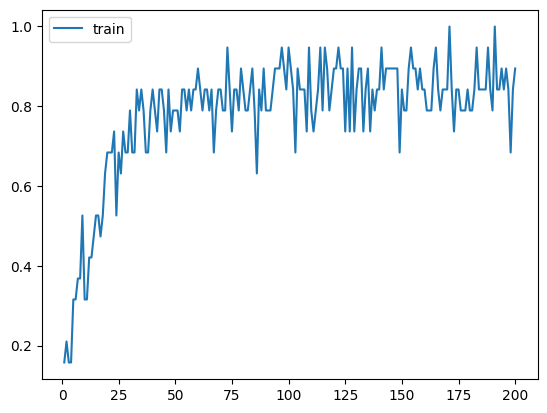

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [ ]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: cuando estés lento a la medio estás te ni alejando despacito de ella tu rueda derecha muy delante hacia pared y gira tu rueda muy delante más hacia pared
1/1 [==============================] - 0s 139ms/step
BOT: si te estás acercando a la pared pero aún estás lejos, gira tu rueda izquierda más o menos rápido hacia adelante y la derecha muy lento adelante 


### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.